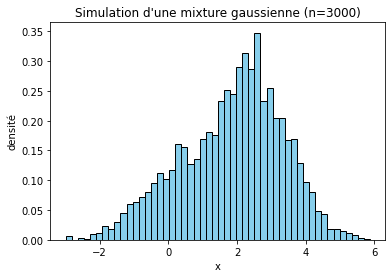

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

n = 3000
pi0, pi1 = 1/4, 3/4
mu0_true, mu1_true = 0, 2.5
sigma = 1

def generate_data(n, pi0, mu0, mu1, sigma):
    Z = np.random.choice([0, 1], size=n, p=[pi0, 1-pi0])
    return np.where(Z == 0,
                   np.random.normal(mu0, sigma, n),
                   np.random.normal(mu1, sigma, n))

data = generate_data(n, pi0, mu0_true, mu1_true, sigma)

plt.hist(data, bins=50, density=True, color='skyblue', edgecolor='black')
plt.title("Simulation d'une mixture gaussienne (n=3000)")
plt.xlabel("x")
plt.ylabel("densité")
plt.show()


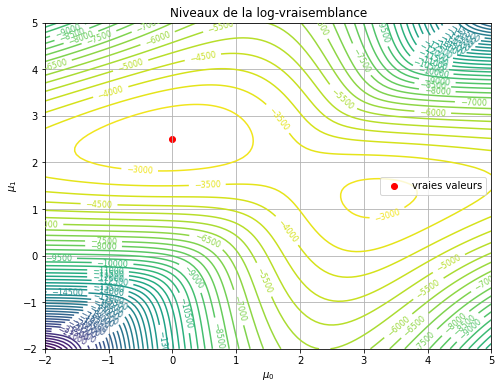

In [33]:
def log_likelihood(mu0, mu1, X, pi0, pi1, sigma=1):
    term0 = pi0 * np.exp(-0.5 * ((X - mu0)/sigma)**2)
    term1 = pi1 * np.exp(-0.5 * ((X - mu1)/sigma)**2)
    return np.sum(np.log(term0 + term1))

mu0_vals = np.linspace(-2, 5, 100)
mu1_vals = np.linspace(-2, 5, 100)
LL = np.zeros((len(mu0_vals), len(mu1_vals)))

for i, mu0i in enumerate(mu0_vals):
    for j, mu1i in enumerate(mu1_vals):
        LL[i, j] = log_likelihood(mu0i, mu1i, data, pi0, pi1)

plt.figure(figsize=(8, 6))
contours = plt.contour(mu0_vals, mu1_vals, LL.T, levels=50, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel(r'$\mu_0$')
plt.ylabel(r'$\mu_1$')
plt.title('Niveaux de la log-vraisemblance')
plt.scatter(mu0_true, mu1_true, color='red', label='vraies valeurs')
plt.legend()
plt.grid(True)
plt.show()



Initialisation 1: μ0=-1, μ1=1
Convergence atteinte après 20 itérations
Résultat final: μ0=0.0340, μ1=2.4958
Vitesse de convergence: 20 itérations

Initialisation 2: μ0=1, μ1=3
Convergence atteinte après 20 itérations
Résultat final: μ0=0.0340, μ1=2.4958
Vitesse de convergence: 20 itérations

Initialisation 3: μ0=2.5, μ1=0
Convergence atteinte après 19 itérations
Résultat final: μ0=3.2038, μ1=1.2545
Vitesse de convergence: 19 itérations

Initialisation 4: μ0=5, μ1=-1
Convergence atteinte après 18 itérations
Résultat final: μ0=3.2038, μ1=1.2545
Vitesse de convergence: 18 itérations


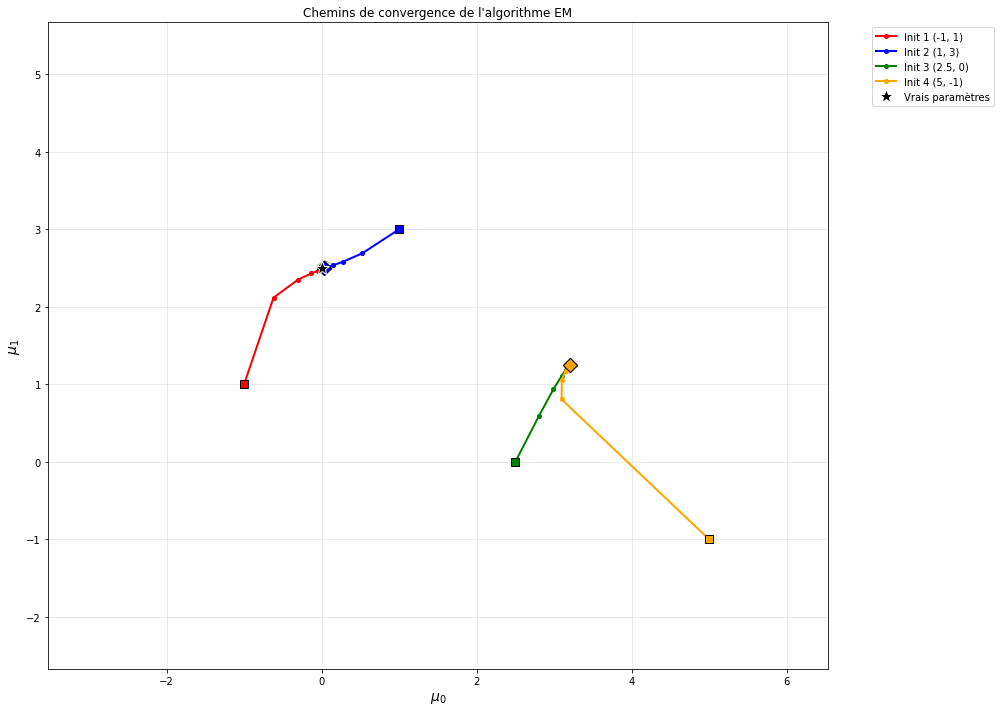

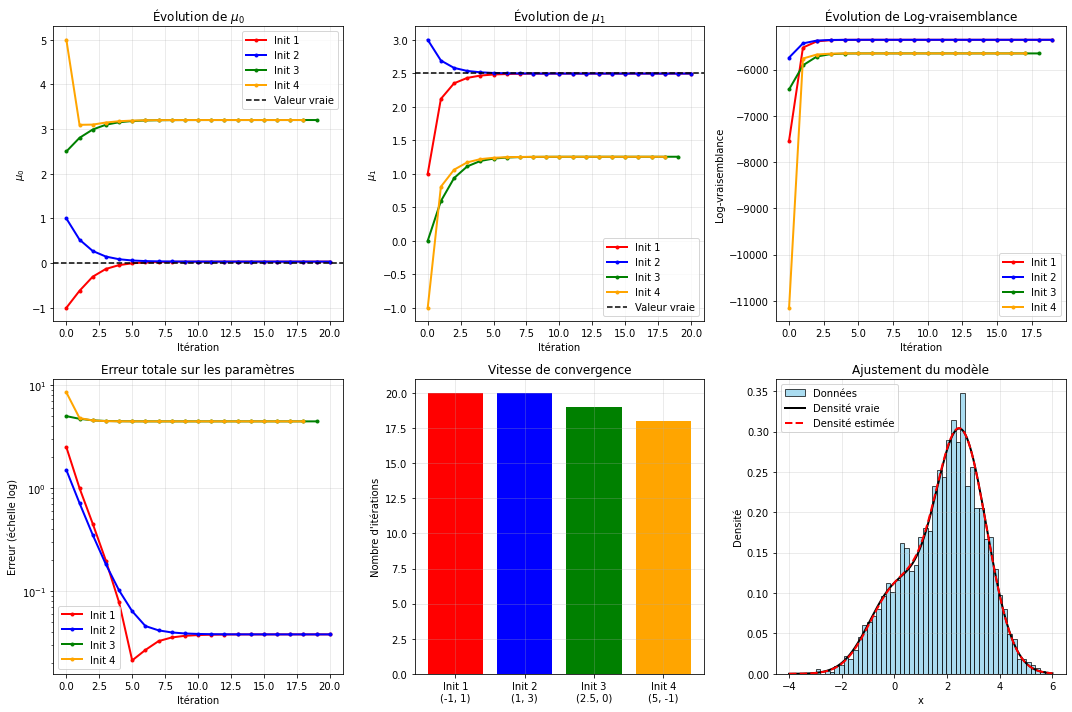

Meilleur résultat (selon vraisemblance): init_2
Paramètres estimés: μ0=0.0340, μ1=2.4958
Log-vraisemblance: -2596.3168


In [34]:
def EM_algorithm(data, initial_params, pi0, pi1, max_iter=1000, tol=1e-6):
    mu0, mu1 = initial_params
    history = {'mu0': [mu0], 'mu1': [mu1], 'log_lik': []}
    
    for iteration in range(max_iter):
        prob0 = pi0 * norm.pdf(data, loc=mu0, scale=sigma)
        prob1 = pi1 * norm.pdf(data, loc=mu1, scale=sigma)
        tau1 = prob1 / (prob0 + prob1)
        tau0 = 1 - tau1
        
        mu0_new = np.sum(tau0 * data) / np.sum(tau0)
        mu1_new = np.sum(tau1 * data) / np.sum(tau1)
        
        log_lik = np.sum(np.log(prob0 + prob1))
        history['log_lik'].append(log_lik)
        
        error = abs(mu0_new - mu0) + abs(mu1_new - mu1)
        mu0, mu1 = mu0_new, mu1_new
        history['mu0'].append(mu0)
        history['mu1'].append(mu1)
        
        if error < tol:
            print(f"Convergence atteinte après {iteration+1} itérations")
            break
    
    return (mu0, mu1), history

def plot_convergence_paths(results, mu0_true, mu1_true, mu_range=(-2, 5, 80)):
    mu0_range = np.linspace(*mu_range)
    mu1_range = np.linspace(*mu_range)
    Mu0, Mu1 = np.meshgrid(mu0_range, mu1_range)
    
    log_lik_grid = np.zeros_like(Mu0)
    for i, mu0_val in enumerate(mu0_range):
        for j, mu1_val in enumerate(mu1_range):
            log_lik_grid[j, i] = log_likelihood(mu0_val, mu1_val, data, pi0, pi1)
    
    lik_grid_normalized = np.exp(log_lik_grid - np.max(log_lik_grid))
    
    plt.figure(figsize=(14, 10))
    contour_levels = np.linspace(0.1, 1.0, 10)
    plt.contour(Mu0, Mu1, lik_grid_normalized, levels=contour_levels, 
                colors='black', alpha=0.4, linewidths=0.8)
    plt.contourf(Mu0, Mu1, lik_grid_normalized, levels=contour_levels, 
                cmap='Greys', alpha=0.3)
    
    colors = ['red', 'blue', 'green', 'orange']
    for i, (key, result) in enumerate(results.items()):
        mu0_path, mu1_path = result['history']['mu0'], result['history']['mu1']
        plt.plot(mu0_path, mu1_path, 'o-', color=colors[i], linewidth=2, 
                markersize=4, label=f'Init {i+1} {result["initial"]}')
        plt.plot(mu0_path[0], mu1_path[0], 's', color=colors[i], markersize=8, markeredgecolor='black')
        plt.plot(mu0_path[-1], mu1_path[-1], 'D', color=colors[i], markersize=10, markeredgecolor='black')
    
    plt.plot(mu0_true, mu1_true, 'k*', markersize=15, label='Vrais paramètres', markeredgecolor='white')
    plt.xlabel('$\mu_0$', fontsize=14)
    plt.ylabel('$\mu_1$', fontsize=14)
    plt.title('Chemins de convergence de l\'algorithme EM', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

initializations = [(-1, 1), (1, 3), (2.5, 0), (5, -1)]
results = {}

for i, init in enumerate(initializations):
    print(f"\nInitialisation {i+1}: μ0={init[0]}, μ1={init[1]}")
    final_params, history = EM_algorithm(data, init, pi0, pi1)
    results[f'init_{i+1}'] = {
        'initial': init,
        'final': final_params,
        'history': history,
        'convergence_speed': len(history['mu0']) - 1
    }
    print(f"Résultat final: μ0={final_params[0]:.4f}, μ1={final_params[1]:.4f}")
    print(f"Vitesse de convergence: {len(history['mu0']) - 1} itérations")

plot_convergence_paths(results, mu0_true, mu1_true)

plt.figure(figsize=(15, 10))
colors = ['red', 'blue', 'green', 'orange']

metrics = [
    ('mu0', '$\mu_0$', mu0_true),
    ('mu1', '$\mu_1$', mu1_true),
    ('log_lik', 'Log-vraisemblance', None)
]

for idx, (metric, ylabel, true_val) in enumerate(metrics):
    plt.subplot(2, 3, idx + 1)
    for i, (key, result) in enumerate(results.items()):
        iterations = range(len(result['history'][metric]))
        values = result['history'][metric]
        plt.plot(iterations, values, 'o-', color=colors[i], 
                label=f'Init {i+1}', linewidth=2, markersize=3)
    
    if true_val is not None:
        plt.axhline(y=true_val, color='black', linestyle='--', label='Valeur vraie')
    
    plt.xlabel('Itération')
    plt.ylabel(ylabel)
    plt.title(f'Évolution de {ylabel}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
for i, (key, result) in enumerate(results.items()):
    iterations = range(len(result['history']['mu0']))
    errors = [abs(result['history']['mu0'][j] - mu0_true) + 
              abs(result['history']['mu1'][j] - mu1_true) for j in iterations]
    plt.semilogy(iterations, errors, 'o-', color=colors[i], 
                label=f'Init {i+1}', linewidth=2, markersize=3)
plt.xlabel('Itération')
plt.ylabel('Erreur (échelle log)')
plt.title('Erreur totale sur les paramètres')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
init_labels = [f'Init {i+1}\n{results[f"init_{i+1}"]["initial"]}' for i in range(len(results))]
convergence_speeds = [results[f'init_{i+1}']['convergence_speed'] for i in range(len(results))]
plt.bar(init_labels, convergence_speeds, color=colors[:len(results)])
plt.ylabel('Nombre d\'itérations')
plt.title('Vitesse de convergence')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.hist(data, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Données')

x_plot = np.linspace(-4, 6, 1000)
pdf_true = pi0 * norm.pdf(x_plot, mu0_true, sigma) + pi1 * norm.pdf(x_plot, mu1_true, sigma)
plt.plot(x_plot, pdf_true, 'k-', linewidth=2, label='Densité vraie')

final_likelihoods = {}
for key, result in results.items():
    mu0, mu1 = result['final']
    final_log_lik = log_likelihood(mu0, mu1, data, pi0, pi1)
    final_likelihoods[key] = final_log_lik

best_key = max(final_likelihoods, key=final_likelihoods.get)
best_result = results[best_key]
mu0_est, mu1_est = best_result['final']

pdf_est = pi0 * norm.pdf(x_plot, mu0_est, sigma) + pi1 * norm.pdf(x_plot, mu1_est, sigma)
plt.plot(x_plot, pdf_est, 'r--', linewidth=2, label='Densité estimée')

plt.xlabel('x')
plt.ylabel('Densité')
plt.title('Ajustement du modèle')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Meilleur résultat (selon vraisemblance): {best_key}")
print(f"Paramètres estimés: μ0={best_result['final'][0]:.4f}, μ1={best_result['final'][1]:.4f}")
print(f"Log-vraisemblance: {final_likelihoods[best_key]:.4f}")
